In [5]:
import gdown

# File ID from the Google Drive link
file_id = "1118Jwzj51KpXd0T5jiebn9ykCygwbkhn"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
output = "dataset.csv"  # Change this to match your file type
gdown.download(url, output, quiet=False)

print("Download complete!")


Downloading...
From (original): https://drive.google.com/uc?id=1118Jwzj51KpXd0T5jiebn9ykCygwbkhn
From (redirected): https://drive.google.com/uc?id=1118Jwzj51KpXd0T5jiebn9ykCygwbkhn&confirm=t&uuid=674a1194-117c-472d-8b0e-98201475c5e0
To: /Users/ayesha/Library/CloudStorage/OneDrive-Personal/Credit-Card-Fraud-Detection/dataset.csv
100%|██████████| 351M/351M [02:57<00:00, 1.97MB/s] 

Download complete!


In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,roc_curve,auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib

In [11]:
df= pd.read_csv("dataset.csv")
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [12]:
df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'])
df['hour']=df['trans_date_trans_time'].dt.hour
df['month']=df['trans_date_trans_time'].dt.month
df['day']=df['trans_date_trans_time'].dt.day


In [17]:
drop_columns=['Unnamed :0','trans_date_trans_time','first','last','street','city','state','zip','dob','job','trans_num']
df = df.drop(columns=[col for col in drop_columns if col in df.columns])


In [18]:
df.head()

,Unnamed: 0,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,month,day
0,0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1
1,1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1
2,2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1
3,3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1
4,4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1


In [19]:
cat_col=['merchant','category','gender']
encoders={}
for col in cat_col:
    encoders[col]=LabelEncoder()
    df[col]=encoders[col].fit_transform(df[col])


In [21]:
def havedistance(lat1,lon1,lat2,lon2):
    return np.array([geodesic((a,b),(c,d)).km for a,b,c,d in zip(lat1,lon1,lat2,lon2)])

df['distance']=havedistance(df['lat'],df['long'],df['merch_lat'],df['merch_long'])


In [22]:
df.head()

,Unnamed: 0,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,month,day,distance
0,0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395


In [24]:
features=['merchant','category','amt','cc_num','hour','day','month','gender','distance']
x=df[features]
y=df['is_fraud']

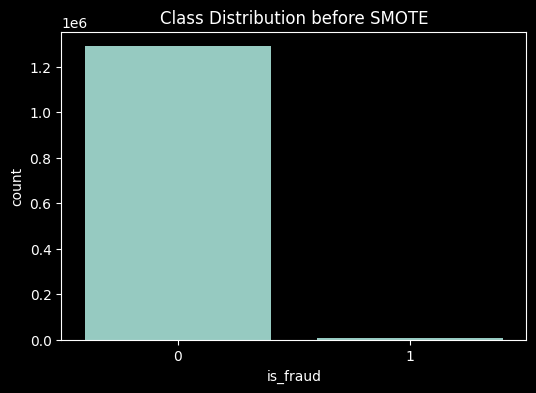

In [49]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud',data=df)
plt.style.use("dark_background")
plt.title('Class Distribution before SMOTE')
plt.show()

In [27]:
smote=SMOTE(random_state=42)
x_resample,y_resample=smote.fit_resample(x,y)


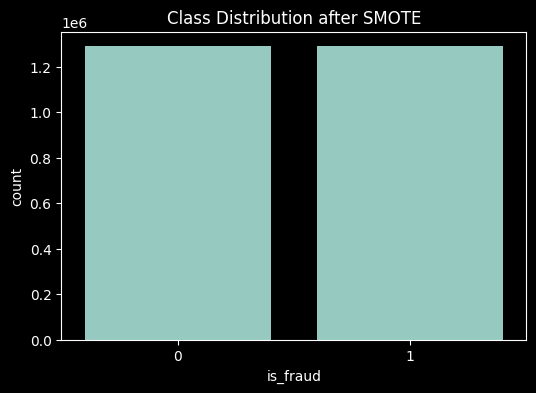

In [50]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title('Class Distribution after SMOTE')
plt.show()
plt.style.use("dark_background")

In [33]:
x_train,x_test,y_train,y_test=train_test_split(x_resample,y_resample,test_size=0.2,random_state=42)

In [34]:
lgb_model=lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metrics='auc',
    is_unbalance= True,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=1,
    n_estimators=200,
)
lgb_model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 1030687, number of negative: 1031983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499686 -> initscore=-0.001257
[LightGBM] [Info] Start training from score -0.001257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=1,
               metrics='auc', n_estimators=200, objective='binary')

In [36]:
y_pred=lgb_model.predict(x_test)


In [37]:
print("Classification_Report: \n",classification_report(y_test,y_pred))
print("Roc AUC Score: ",roc_auc_score(y_test,y_pred))


Classification_Report: 
               precision    recall  f1-score   support

           0       0.82      0.95      0.88    257186
           1       0.94      0.79      0.86    258482

    accuracy                           0.87    515668
   macro avg       0.88      0.87      0.87    515668
weighted avg       0.88      0.87      0.87    515668

Roc AUC Score:  0.8705843871959739


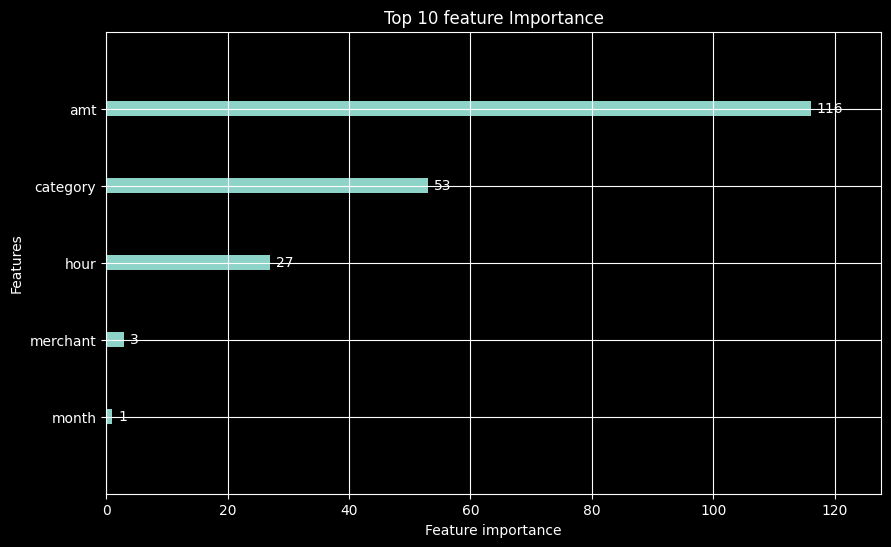

In [48]:
lgb.plot_importance(lgb_model,max_num_features=10,importance_type='split',figsize=(10,6))
plt.title("Top 10 feature Importance")
plt.style.use("dark_background")
plt.show()

In [39]:
fpr,tpr,thresholds=roc_curve(y_test,lgb_model.predict_proba(x_test)[:,1])
roc_auc=auc(fpr,tpr)


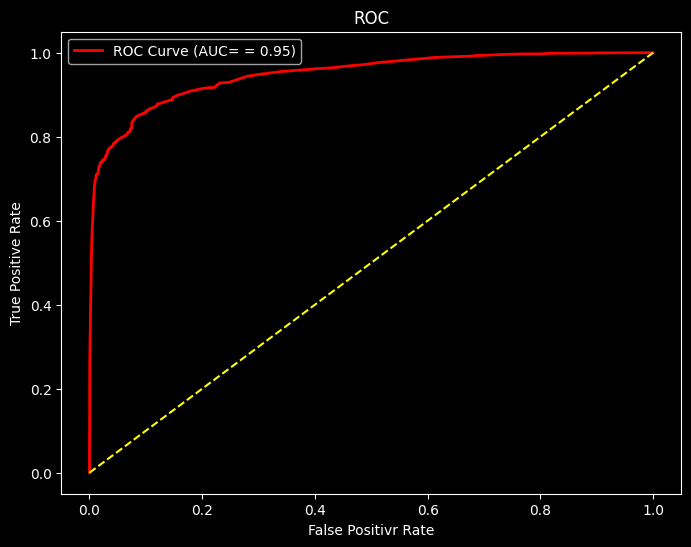

In [47]:
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='red',lw=2,label=f'ROC Curve (AUC= = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='yellow', linestyle='--')  

plt.title("ROC")
plt.style.use("dark_background")
plt.xlabel('False Positivr Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [51]:
joblib.dump(lgb_model,'credit_card_fraud_detect_model.jb')
joblib.dump(encoders,'label_encoder.jb')


['label_encoder.jb']